In [ ]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Missing data and rerun EDA
- handle missing data 
- rerun through the eda steps with clean data
- run boruta analysis for feature selection

In [2]:
# inspect dataset
radiomics_df = pd.read_csv("../motum/merged_radiomics_data.csv")
radiomics_df['modality'] = radiomics_df['Image'].str.extract(r"/([^/]+)\.nii\.gz$")[0]
radiomics_df['modality'].unique()
print(radiomics_df.shape)
print(radiomics_df.head())

# merge with metadata on subject_id
meta_df = pd.read_csv("../motum/Participants_wlabels.csv")
meta_headers = list(meta_df.columns)
merge_df = radiomics_df.merge(meta_df, how='left', left_on='subject_id', right_on='ID', validate='many_to_one')
print(merge_df.shape)
print(merge_df.columns)

def collapse_ratings(df, modality_col="modality", suffix="_img_rating"):
    """
    collapse modality-specific rating columns into a single column
    'img_rating' that matches the row's modality
    """
    df = df.copy()
    rating_cols = [c for c in df.columns if c.endswith(suffix)]

    modality_to_col = {c.replace(suffix, ""): c for c in rating_cols}

    # get col that matches modality
    target_cols = df[modality_col].map(modality_to_col)

    # collapse into new col corresponding rating
    col_indices = df.columns.get_indexer(target_cols)
    row_indices = np.arange(len(df))

    df["img_rating"] = df.to_numpy()[row_indices, col_indices]

    df = df.drop(columns=rating_cols)

    return df

merge_df = collapse_ratings(merge_df)
merge_df.columns
merge_df.head()

(268, 140)
                                               Image  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

                                                Mask  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.19.5   
1                           v3.0.1                     1.19.5   
2                           v3.0.1                     1.19.5   
3                              NaN                     

,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,IDH,GFAP,P53,Ki-67,Olig-2,surg_or_biop,EOR,molec_result,label,img_rating
0,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},61e7c5403a3ba6d0730ef745a8025d22e8e66aa7,...,/,/,/,/,/,Surgery,Subtotal resection (STR),"ER (90%+), PR (90%+), HER-2 (+), Ki-67 (10%+),...",metastasis,2
1,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},83d7595732eb5ffbad78cadb70095e0067914ba7,...,/,/,/,/,/,Surgery,Subtotal resection (STR),"CK7 (+), Ckpan(+), Napsin-A (-), TTF-1 (+), CK...",metastasis,2
2,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f182546914a5acb19d02ea31916f9c1ccd83da11,...,mutant,+,+,30%+,+,Surgery,Gross total resection (GTR),/,glioma,2
3,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,wildtype,+,-,10%+,+,Surgery,Gross total resection (GTR),/,glioma,2
4,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/,/,/,/,/,Biopsy,Biopsy,-,metastasis,2


In [3]:
print(merge_df.columns)

Index(['Image', 'Mask', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       ...
       'IDH', 'GFAP', 'P53', 'Ki-67', 'Olig-2', 'surg_or_biop', 'EOR',
       'molec_result', 'label', 'img_rating'],
      dtype='object', length=156)


### Rerun through eda steps and investigate missing values:

In [4]:
# non_rad_feats = ["ManufacturerModelName","RepetitionTime","EchoTime","InversionTime","FlipAngle","SliceThickness","PixelSpacing", "Image","Mask"]

feat_families = {}
feat_cols = []
for c in merge_df.columns:
    if c.startswith("original_"): # only looking at num feats
        fam = c.split("_")[1]
        feat_families[fam] = feat_families.get(fam, 0) + 1
        feat_cols.append(c)

# no of feats in each family
print(feat_families)
print(feat_cols)

{'shape': 14, 'firstorder': 18, 'glcm': 24, 'gldm': 14, 'glrlm': 16, 'glszm': 16, 'ngtdm': 5}
['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAb

In [5]:
# ------------ handle missing data ------------
# overall
print(merge_df.isna().sum())

# groupy by modality
na_by_mod = merge_df.groupby("modality")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"avg NA across features (by modality):\n {na_by_mod}")

# group by subject
na_by_subj = merge_df.groupby("subject_id")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"\navg NA across features (by subject):\n{na_by_subj}")
print(f"\nThese subjects are have most NA:{na_by_subj[na_by_subj > 0.25]}")

Image                                0
Mask                                 0
diagnostics_Versions_PyRadiomics    73
diagnostics_Versions_Numpy          73
diagnostics_Versions_SimpleITK      73
                                    ..
surg_or_biop                         0
EOR                                  0
molec_result                         0
label                                0
img_rating                           0
Length: 156, dtype: int64
avg NA across features (by modality):
 modality
flair    0.044776
t1       0.044776
t1ce     0.955224
t2       0.044776
dtype: float64

avg NA across features (by subject):
subject_id
sub-0001    0.25
sub-0002    0.25
sub-0003    0.25
sub-0004    0.25
sub-0005    0.25
            ... 
sub-0063    0.25
sub-0064    0.25
sub-0065    0.25
sub-0066    0.25
sub-0067    0.25
Length: 67, dtype: float64

These subjects are have most NA:subject_id
sub-0024    1.0
sub-0048    1.0
sub-0057    1.0
dtype: float64


majority of missingness is associated with t1ce and the subjects sub-0024, sub-0048 and sub-0057
drop these for downstream consideration

In [6]:
# remove t1ce and subjects with high missingness
print(merge_df.shape)
subj_to_drop = ["sub-0024", "sub-0048", "sub-0057"]
df = merge_df[
    (merge_df["modality"] != "t1ce") &
    (~merge_df['subject_id'].isin(subj_to_drop))
    ] 
print(df.shape)

# overall
print(df.isna().sum())

(268, 156)
(192, 156)
Image                               0
Mask                                0
diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
                                   ..
surg_or_biop                        0
EOR                                 0
molec_result                        0
label                               0
img_rating                          0
Length: 156, dtype: int64


At this stage, the data is clean of most NAs. We know from our EDA that the shape features are not informative and we want to consider numerical radiomics features only:
- we remove those from consideration
- rename the variables to clean it up (drop original_)
- redo correlation plots

107
93
Index(['Image', 'Mask', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       ...
       'IDH', 'GFAP', 'P53', 'Ki-67', 'Olig-2', 'surg_or_biop', 'EOR',
       'molec_result', 'label', 'img_rating'],
      dtype='object', length=156)
['firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Energy', 'firstorder_Entropy', 'firstorder_InterquartileRange', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean', 'firstorder_Median', 'firstorder_Minimum', 'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_RootMeanSquared', 'firstorder_Skewness', 'firstorder_TotalEnergy', 'firstorder_Uniformity', 'firstorder_Variance', 'glcm_Autocorrelation',

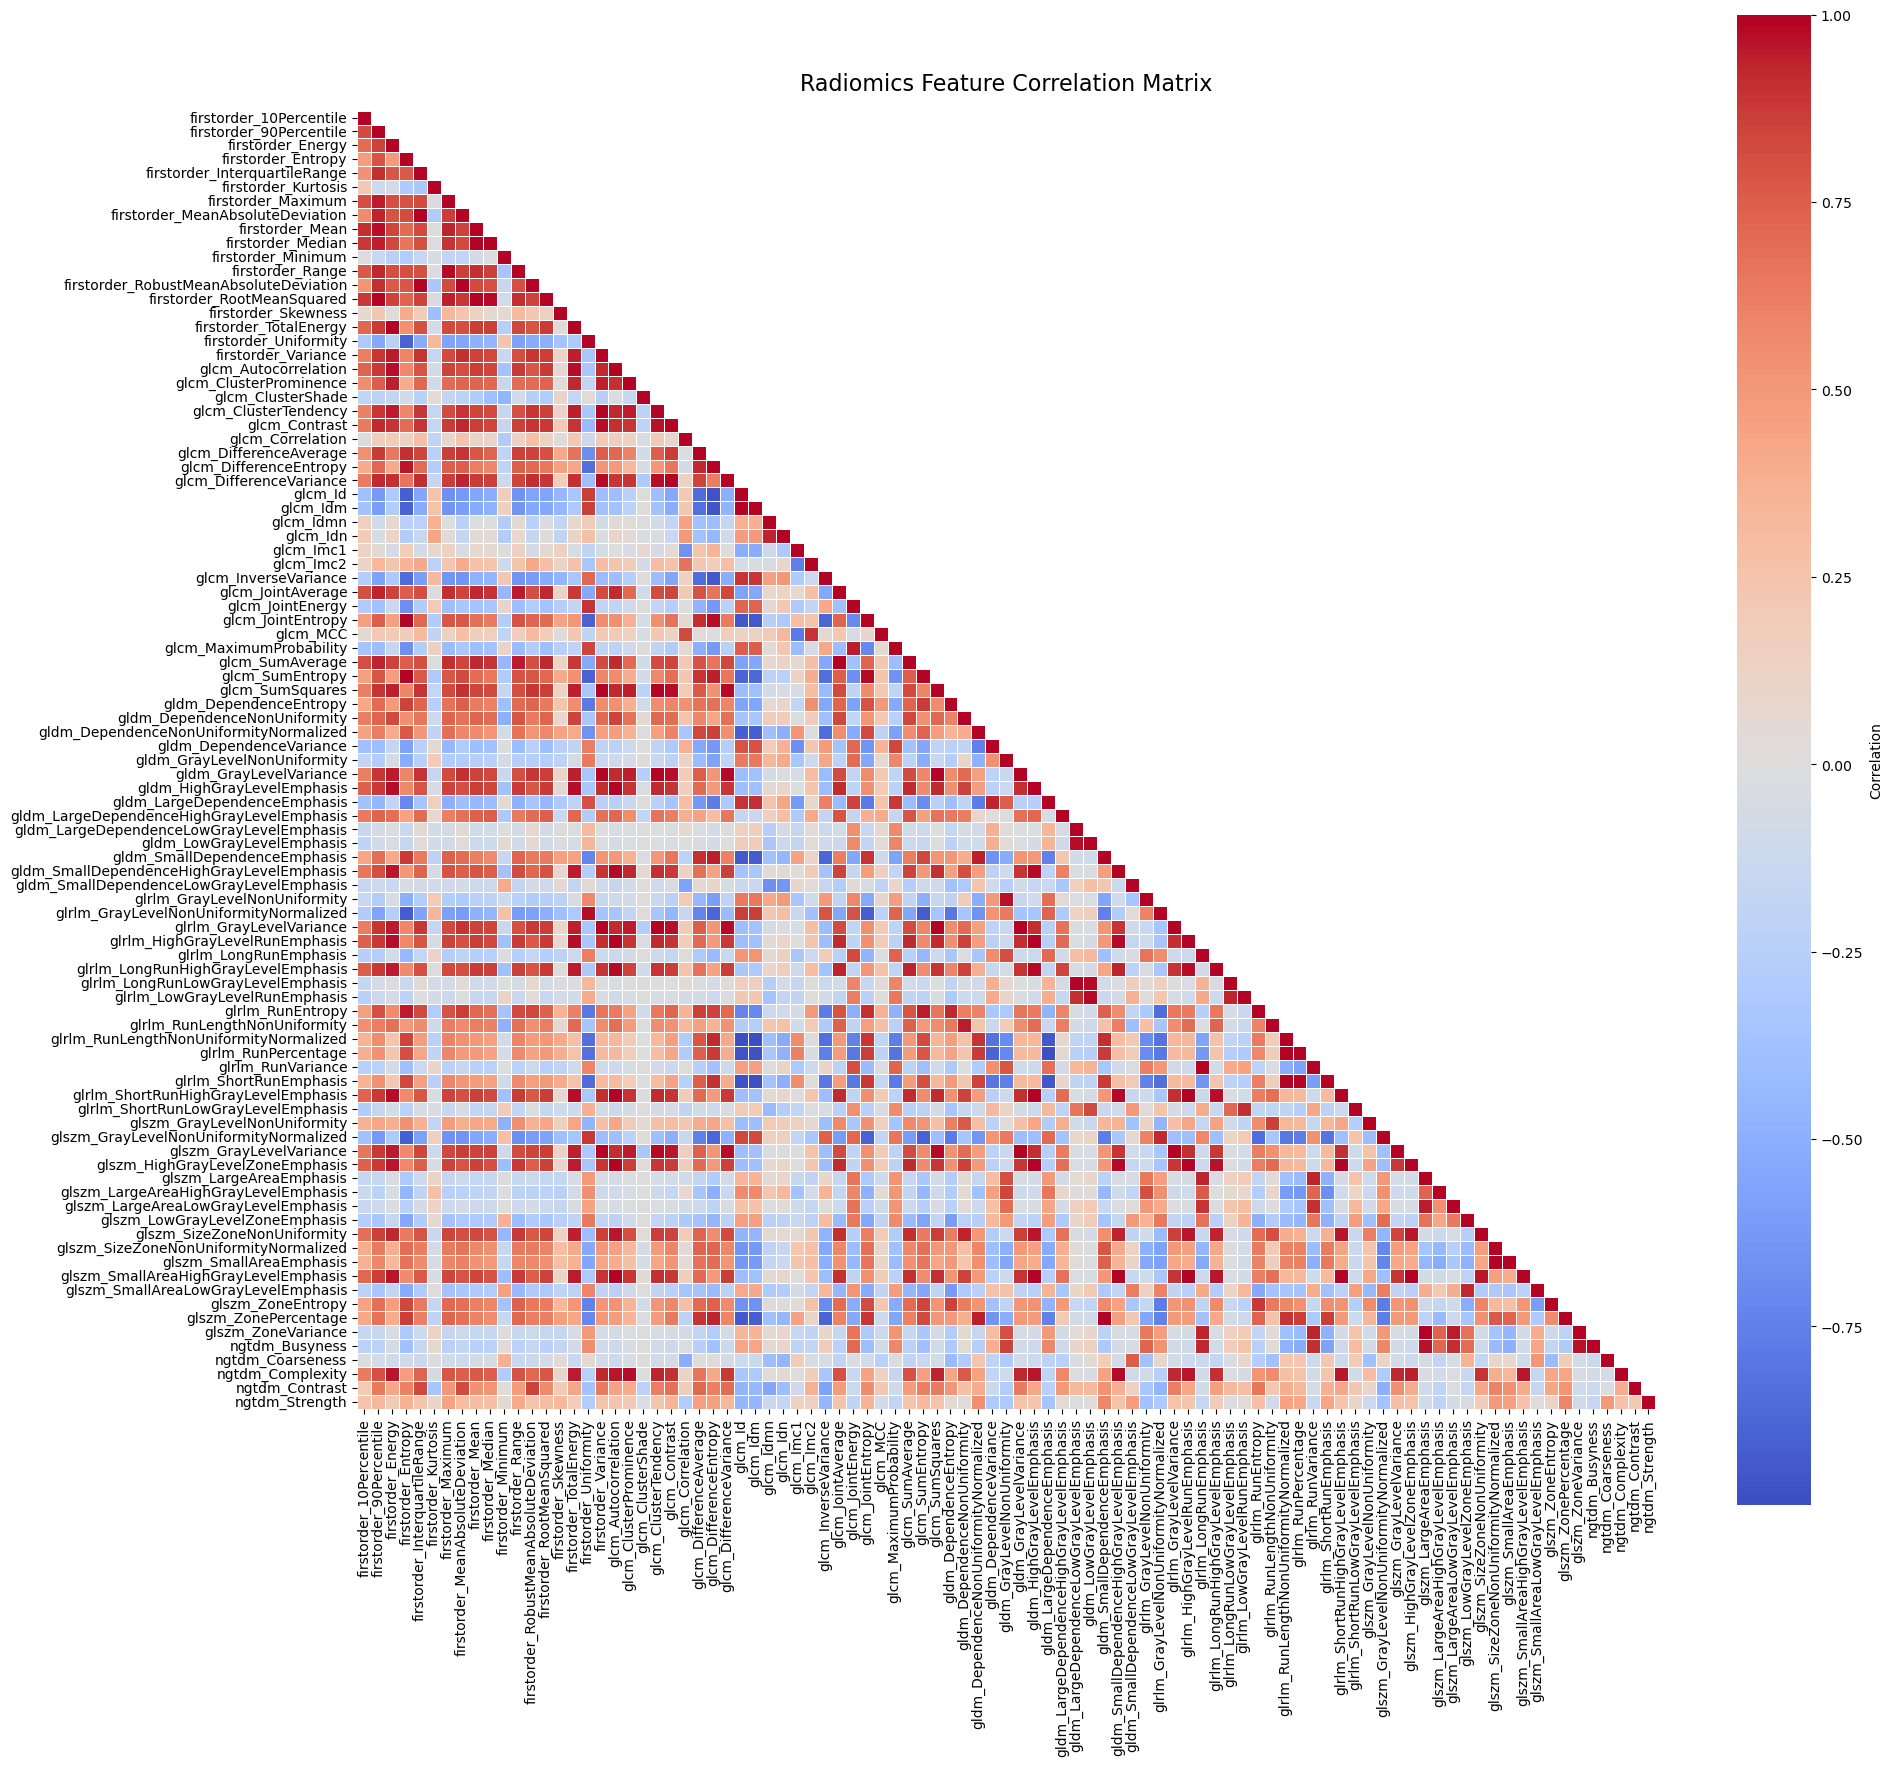

In [7]:
# drop shape features
print(len(feat_cols))
# print(feat_cols)
filt_feat_cols = [f for f in feat_cols if 'shape' not in f]
print(len(filt_feat_cols))
# print(filt_feat_cols)

# remove prefixes
df.columns = df.columns.str.removeprefix("original_")
rad_feat_cols = [c.replace("original_", "", 1) for c in filt_feat_cols]
print(df.columns)
print(rad_feat_cols)


param_cols = [
    "modality", "ManufacturerModelName",
    "RepetitionTime", "EchoTime", "InversionTime",
    "FlipAngle", "SliceThickness", # dropped Pixel space since invalid type
]

meta_headers.extend(param_cols)
meta_cols = [i for i in meta_headers if not i.endswith("img_rating")]
meta_cols.append("img_rating")
meta_cols.remove("label")

rad_feat_df = df[rad_feat_cols]
meta_df = df[meta_cols]

# correlation plots
corr = rad_feat_df.corr()

def get_lower_tri_heatmap(df):
    #https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 18))

    # # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"label": "Correlation"},
            xticklabels=corr.columns, yticklabels=corr.columns)
    return sns_plot

get_lower_tri_heatmap(corr)
plt.title("Radiomics Feature Correlation Matrix", fontsize=16, pad=15)
plt.tight_layout()
plt.show()


Data is clean and collated as meta_df (rad_feat_df if radiomics data only). The radiomics columns are rad_feat_cols while the metadata cols are meta_headers.

## Feature Engineering


Boruta is a python wrapper of the random forest algorithm. It performs a statistical test to assess the importance of features relative to synthetic permutations of features
https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596/ 

key variables:
- X_rad: radiomics df
- X_met: metadata df
- y: labels (glioma or metastasis)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [ ]:
# from above:
# rad_feat_df = df[rad_feat_cols]
# meta_df = df[meta_cols]

rad_feat_cols.append("subject_id")
X_rad = df[rad_feat_cols]
X_clin = df[meta_cols]
y = df['label']

# data is such that there are multiple modalities for each subject
# split to ensure no data leakage (e.g. same patient appearing in train and test)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X_rad, y, groups=df["subject_id"]))

X_rad_train, X_rad_test = X_rad.iloc[train_idx], X_rad.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# split clin data and response var on same idx
X_clin_train, X_clin_test = X_clin.iloc[train_idx], X_clin.iloc[test_idx]

# drop subject id
X_rad_sub_train = X_rad_train.drop("subject_id", axis=1)
X_rad_sub_test = X_rad_test.drop("subject_id", axis=1)

# BORUTA - help pls D: 

rf = RandomForestClassifier(
    n_jobs=-1,
    max_depth=5,
    class_weight='balanced',
    random_state=42
    )
boruta = BorutaPy(
    estimator=rf,
    perc=90,
    n_estimators='auto',
    max_iter=200,
    two_step=True,
    random_state=42,
    )


boruta.fit(X_rad_sub_train.values, y_train.values)

selected = X_rad_sub_train.columns[boruta.support_]
print(f"Selected features: {len(selected)}")


Selected features: 4


Initially got no feats tried a few variables to make it less strict - logging doc refs here for report ease later:
- for RandomForestClassifier
    - max_depth: shallower tree

- for Boruta: https://github.com/scikit-learn-contrib/boruta_py 
    - perc: 100 -> 90
    The original method uses the maximum of the shadow features as a threshold in deciding which real feature is doing better than the shadow ones. This could be overly harsh.
    - max_iter: 100 (default) -> 200 (more iter)
    - two_step: False (default) -> True
    The correction for multiple testing was relaxed by making it a two step process, rather than a harsh one step Bonferroni correction.


Possible next steps:
- try decreasing the strictness more or picking feats w less support
- look into other splitting methods (stratified group k fold) if better for our app
- I think boruta does z standardization (?) but maybe we can preprocess data somehow for better signal??

once we select feats we can train model to classify and maybe consider other factors (e.g. centre influence, sex, age, grade etc.)
we should train the model and do cross val (something accounting for stratification by subject so no leakage)

- that should be good for prog report probably 